The data set can be found from here: 
https://open.dosm.gov.my/data-catalogue/labour_labourforce_monthly_16

# 1. Import Library

Idea: by States
       

In [29]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# 2. Load Dataset

        date  unemployed
0 2010-01-01     436.739
1 2010-02-01     427.400
2 2010-03-01     428.300
3 2010-04-01     378.505
4 2010-05-01     398.700


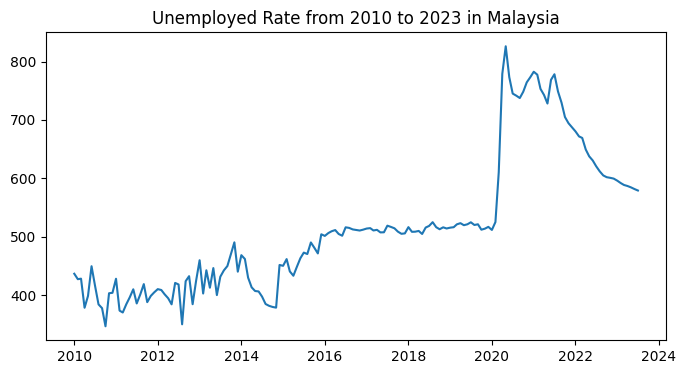

In [23]:
# import data set
data_dir = Path('../datathon')

# read data set
df = pd.read_csv(data_dir / 'labourforce_monthly.csv', parse_dates=['date'])
df.head()

# remove the empty columns
df = df.dropna(axis=1, how='all')

# Remove all the unnecessary columns only left the date and unemployed columns
df = df[['date', 'unemployed']]

# check data type of the variable

# plot the data set
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(df.date, df.unemployed, label='train')

# add title and legend to the plot
plt.title('Unemployed Rate from 2010 to 2023 in Malaysia')

print(df.head())

# 4. Split the Data set into train and test set

In [24]:
import matplotlib.pyplot as plt
# split the data set into train and test
train = df[df.date < '2019-01-01']
test = df[df.date >= '2019-01-01']
train.shape, test.shape

((108, 2), (55, 2))

RMSE value is too high, ARIMA model is not suitable (not stationary data, high autocorrelted)

# 5. Linear Regression with Regression

TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

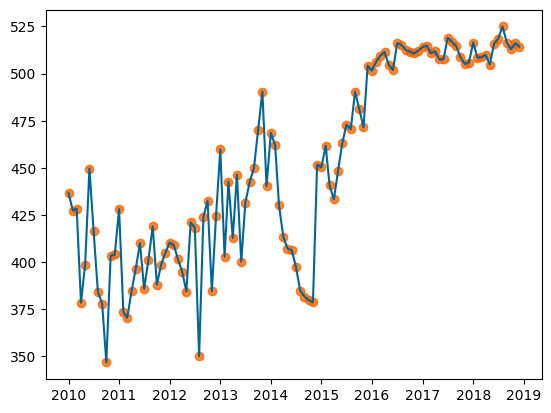

In [25]:
# make the regression plot
fig, ax = plt.subplots()
ax.plot("date", "unemployed", data = train, label='observed', color='#006699')
ax = sns.regplot(x="date", y="unemployed", data = train, label='trend', color='#ff6600')
ax.set_title('Time Plot of Unemployment rate from 2010 to 2019 in Malaysia')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.show()

## 5.1 Fit the feature

### 5.1.1 Create Trend Feature

In [ ]:
df.index = df.date

<Axes: title={'center': 'Tunnel Traffic - 365-Day Moving Average'}, xlabel='date'>

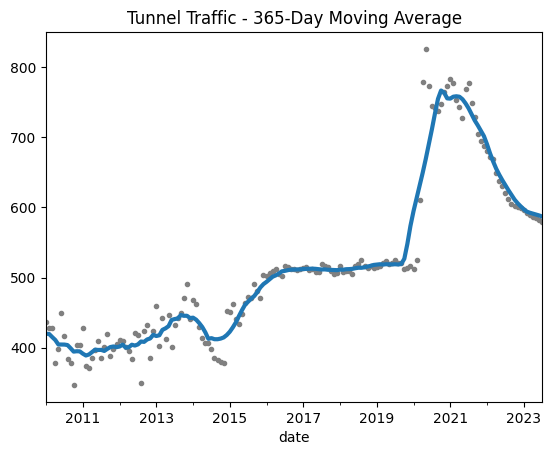

In [ ]:
moving_average = df.unemployed.rolling(
    window=12,       # 12-months window
    center=True,      # puts the average at the center of the window
    min_periods=6,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df.unemployed.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
)

In [ ]:
train['count'] = range(1, len(train) + 1)

X = train[['count']]  # features
y = train['unemployed']  # target

# create the trend feature
dp = DeterministicProcess(
    index=train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=4,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()
X

C:\Users\TAN YU JING\AppData\Local\Temp\ipykernel_4340\3211967724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['count'] = range(1, len(train) + 1)


,const,trend,trend_squared,trend_cubed,trend**4
0,1.0,1.0,1.0,1.0,1.0
1,1.0,2.0,4.0,8.0,16.0
2,1.0,3.0,9.0,27.0,81.0
3,1.0,4.0,16.0,64.0,256.0
4,1.0,5.0,25.0,125.0,625.0
...,...,...,...,...,...
103,1.0,104.0,10816.0,1124864.0,116985856.0
104,1.0,105.0,11025.0,1157625.0,121550625.0
105,1.0,106.0,11236.0,1191016.0,126247696.0
106,1.0,107.0,11449.0,1225043.0,131079601.0


### 5.1.2 Create Seasonality

In [ ]:
# Assuming you have the 'train' DataFrame with a date column
# Convert the date column to a DateTimeIndex
train['date'] = pd.to_datetime(train['date'])
train.index = train['date']

# Calculate the quarter for each timestamp
train['quarter'] = (train.index.month - 1) // 3 + 1

# Create quarterly seasonality indicator variables
train['quarter_Q1'] = (train['quarter'] == 1).astype(int)
train['quarter_Q2'] = (train['quarter'] == 2).astype(int)
train['quarter_Q3'] = (train['quarter'] == 3).astype(int)
train['quarter_Q4'] = (train['quarter'] == 4).astype(int)

# Create the feature matrix (X) including quarterly seasonality indicators
X1 = train[['quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4']]
X1

# remove the quarter column in train
train = train.drop(['quarter_Q1'], axis=1)
train = train.drop(['quarter_Q2'], axis=1)
train = train.drop(['quarter_Q3'], axis=1)
train = train.drop(['quarter_Q4'], axis=1)

C:\Users\TAN YU JING\AppData\Local\Temp\ipykernel_4340\1770895811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = pd.to_datetime(train['date'])
C:\Users\TAN YU JING\AppData\Local\Temp\ipykernel_4340\1770895811.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['quarter'] = (train.index.month - 1) // 3 + 1
C:\Users\TAN YU JING\AppData\Local\Temp\ipykernel_4340\1770895811.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [ ]:
train['date'] = train.index
X['date'] = train['date']
X['date']  = X.index
X.index = pd.to_datetime(X.index)

# Create Seosonal Feature
fourier = CalendarFourier(freq="Q", order=4)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index= train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=4,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                  # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index


## 5.2 Fit the Model

In [32]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=55, forecast_index = test.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Unemployment Rate in Malaysia from 2010 to 2023")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

TypeError: CalendarFourier terms can only be computed from DatetimeIndex and PeriodIndex

Text(0.5, 1.0, 'Time Plot of Unemployment rate from 2010 to 2023 in Malaysia')

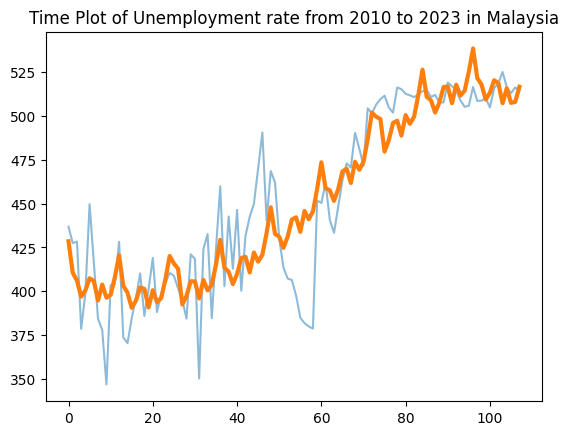

In [31]:
ax = y.plot(alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Unemployment rate from 2010 to 2023 in Malaysia')

## 5.3 Hybrid Forecasting with Residuals

In [ ]:
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2